In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/complaints.csv')


<ipython-input-3-900057001>:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/complaints.csv')


  Date received                                            Product  \
0    2025-06-09  Credit reporting or other personal consumer re...   
1    2025-06-09  Credit reporting or other personal consumer re...   
2    2025-06-09  Credit reporting or other personal consumer re...   
3    2025-06-09  Credit reporting or other personal consumer re...   
4    2025-06-09  Credit reporting or other personal consumer re...   

        Sub-product                                              Issue  \
0  Credit reporting               Incorrect information on your report   
1  Credit reporting               Incorrect information on your report   
2  Credit reporting  Problem with a company's investigation into an...   
3  Credit reporting               Incorrect information on your report   
4  Credit reporting               Incorrect information on your report   

                                           Sub-issue  \
0                Information belongs to someone else   
1                Infor

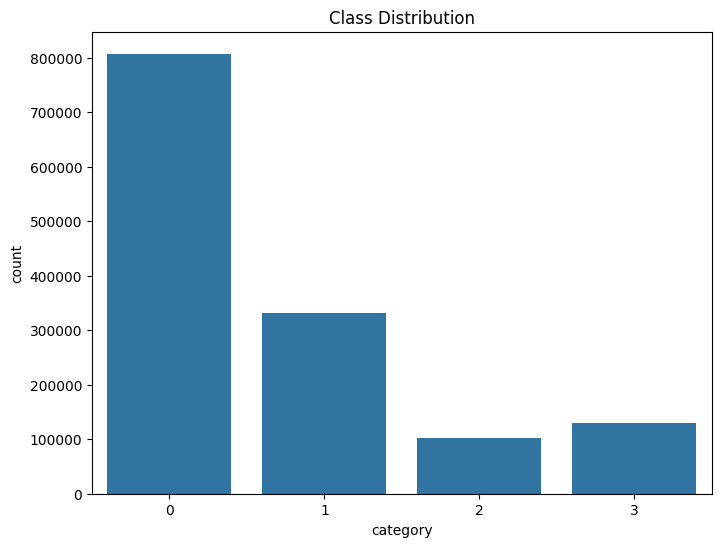

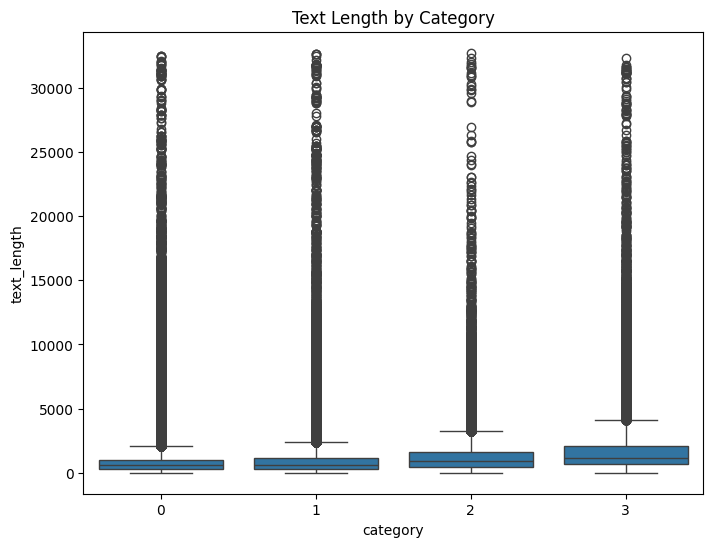

In [4]:

print(df.head())
print(df.info())
print(df.describe())

print(df.isnull().sum())

df = df[['Product', 'Consumer complaint narrative']].dropna()

product_mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Student loan': 2,
    'Payday loan': 2,
    'Vehicle loan or lease': 2,
    'Mortgage': 3
}

df = df[df['Product'].isin(product_mapping.keys())]
df['category'] = df['Product'].map(product_mapping)

# Check class distribution
plt.figure(figsize=(8,6))
sns.countplot(x='category', data=df)
plt.title('Class Distribution')
plt.show()

df['text_length'] = df['Consumer complaint narrative'].apply(len)
plt.figure(figsize=(8,6))
sns.boxplot(x='category', y='text_length', data=df)
plt.title('Text Length by Category')
plt.show()

In [5]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()

    text = ''.join([char for char in text if char not in string.punctuation])

    text = re.sub(r'\d+', '', text)

    words = text.split()

    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

df['cleaned_text'] = df['Consumer complaint narrative'].apply(clean_text)
print(df['cleaned_text'].head())

197     purchased home illinois move louisiana via rea...
237     ive complained procollect false debt continuin...
240     credit collection obtained access consumer cre...
1844    first never received email official notificati...
3124    served appear court either garnishment receive...
Name: cleaned_text, dtype: object


In [6]:

X = df['cleaned_text']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier()
}


results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

plt.figure(figsize=(10,6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.show()

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89    161574
           1       0.78      0.77      0.78     66403
           2       0.65      0.79      0.71     20547
           3       0.83      0.94      0.88     25955

    accuracy                           0.85    274479
   macro avg       0.79      0.84      0.82    274479
weighted avg       0.85      0.85      0.85    274479

Confusion Matrix:
[[140978  12375   5647   2574]
 [ 10880  51229   2720   1574]
 [  1765   1576  16247    959]
 [   579    500    406  24470]]


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93    161574
           1       0.86      0.81      0.83     66403
           2       0.82      0.77      0.80     20547
           3       0.92      0.92      0.92     25955

    accuracy                           0.90    274479
   macro avg    

In [ ]:

best_model = LinearSVC()
cv_scores = cross_val_score(best_model, X_train_tfidf, y_train , cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")

best_model.fit(X_train_tfidf, y_train)

In [ ]:

def predict_complaint(text):
    cleaned_text = clean_text(text)
    text_tfidf = tfidf.transform([cleaned_text])
    prediction = best_model.predict(text_tfidf)[0]

    category_map = {
        0: 'Credit reporting, repair, or other',
        1: 'Debt collection',
        2: 'Consumer Loan',
        3: 'Mortgage'
    }

    return category_map[prediction]

# Example prediction
sample_complaint = """
I've been receiving calls from a debt collector about a credit card debt
that I don't recognize. They're calling multiple times a day.
"""
print(f"Predicted category: {predict_complaint(sample_complaint)}")